# Yield Curve Fitting using Python
by Chee-Foong on 28 Feb 2021

## Summary
An attempt to create the GBP interest rate term structure by building a B-Spline model using Python and how the model made adjustments under various interest rate movement scenarios.

This notebook follows closely to the analysis done by Neil Chandarana as per the links in the reference section below.

## Reference
1. https://towardsdatascience.com/yield-curve-building-in-python-8d7974a6e7e3
2. https://github.com/93tilinfinity/Yield-Curve-Fitting

---

## Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [3]:
import sys  
sys.path.append('../src') 
from bsplines import *

## Data Loading

Price data as of 25 Feb 2021 from:
1. https://www.global-rates.com/en/interest-rates/libor/british-pound-sterling/british-pound-sterling.aspx
2. https://www.theice.com/marketdata/reports/180

In [4]:
DATA_FOLDER = '../data/'

In [5]:
swap_rates = pd.read_csv(DATA_FOLDER + 'ICESwapRateHistoricalRates.csv')
libor_rates = pd.read_csv(DATA_FOLDER + 'gbp-libor.csv')

In [6]:
swap_rates['tenor'] = swap_rates.Tenor.apply(lambda x: x.strip().split(' ')[0]).astype('int')
swap_rates.drop('Tenor', axis=1, inplace=True)
swap_rates.columns = ['rate', 'tenor']
swap_rates = swap_rates[['tenor', 'rate']]

libor_rates.columns = ['tenor', 'rate']

In [7]:
int_rates = pd.concat([libor_rates, swap_rates])
int_rates.reset_index(inplace=True, drop=True)

### Scatter Plot of Yield Curve

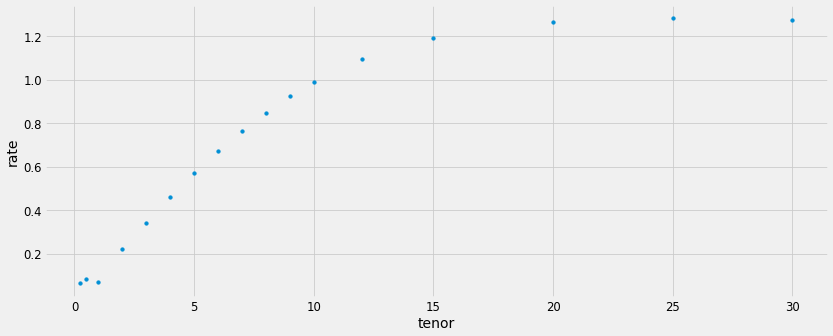

In [8]:
int_rates.plot.scatter(x='tenor', y='rate')
plt.show()

## Model Building - B-Spline

In [9]:
#B-spline Settings
M = 4
knots = [7.25,15.5,22.75]

In [10]:
X = int_rates.tenor.values
Y = int_rates.rate.values

model = Bspline()
model.fit(x=X, y=Y, M=M, knots=knots)

predict = model.predict(x=X)

results = int_rates.copy()
results['predicted'] = predict[0]

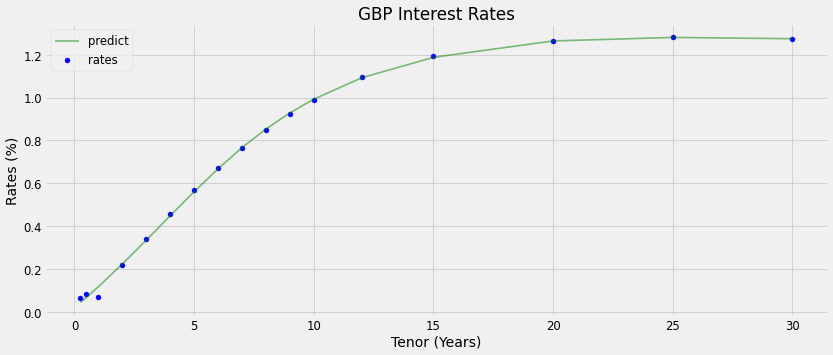

In [11]:
Z = results.predicted

fig, ax = plt.subplots()
ax.scatter(X, Y, color='blue', label='rates')
ax.plot(X, Z, color='green', alpha=0.5, linewidth=2, label='predict')

ax.set_title('GBP Interest Rates')
ax.set_xlabel('Tenor (Years)')
ax.set_ylabel('Rates (%)')

ax.legend()

plt.show()

Notice that the model did not fit the lower end of the yield curve too well.  Adjusting the knot vectors may help.

## Experimenting different knot vectors

In [12]:
kv1 = [7.25, 15.5, 22.75]
kv2 = [3.5, 7.5, 13.5]
kv3 = [1.5, 6.5, 12.5]
kv4 = [0.75,1.5,2.5,6.5,12.5]
kv5 = [1.5,1.5,2.5,6.5,12.5]
kv6 = [0.5,1,2.5,6.5,12.5]
kv_list = [kv1, kv2, kv3, kv4, kv5, kv6]

In [13]:
results = {}

for i, kv in enumerate(kv_list):

    model = Bspline()
    model.fit(x=X, y=Y, M=M, knots=kv)
    predict = model.predict(x=X)

    results['kv'+ str(i+1)] = predict[0].tolist()
    
results = pd.DataFrame(results)
kv_cols = results.columns    

results = pd.concat([int_rates, results], axis=1)

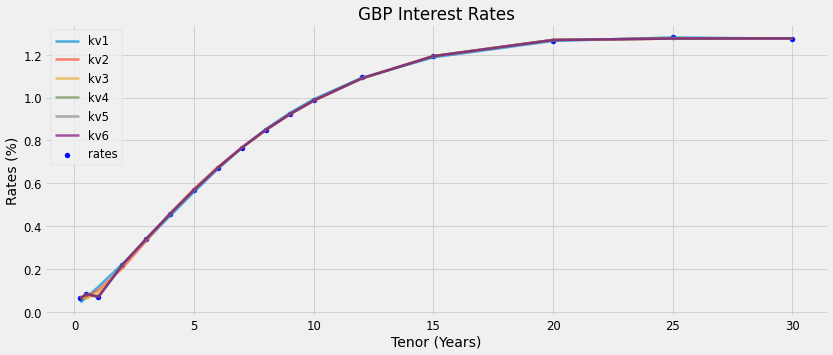

In [14]:
fig, ax = plt.subplots()
ax.scatter(X, Y, color='blue', label='rates')

for col in kv_cols:
    Z = results[col].values
    ax.plot(X, Z, alpha=0.7, linewidth=3, label=col)

ax.set_title('GBP Interest Rates')
ax.set_xlabel('Tenor (Years)')
ax.set_ylabel('Rates (%)')
ax.legend()

plt.show()

Showing the short end interest rate predicted by the model by various B-Spline knots vectors

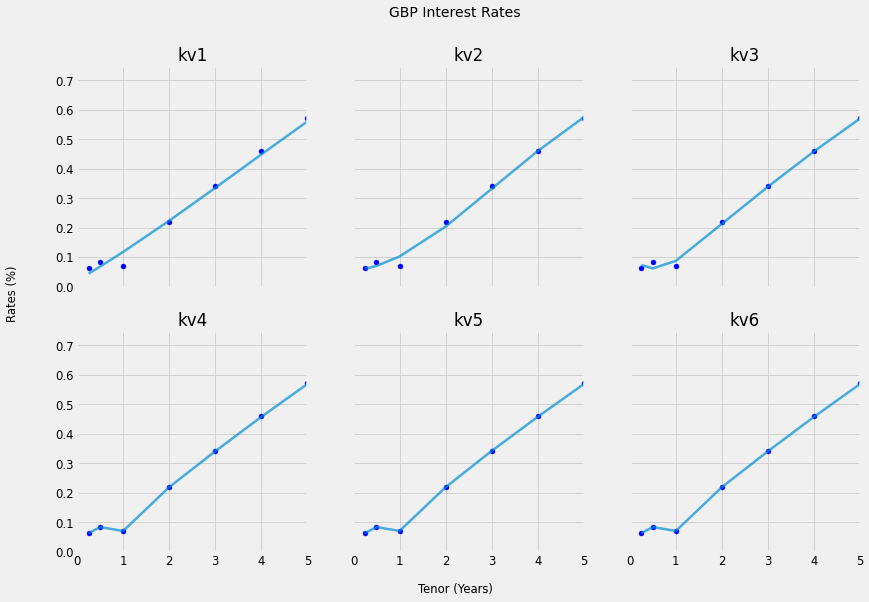

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15,10), sharex='col', sharey='row', constrained_layout=False)

axs = axs.ravel()

for i, col in enumerate(kv_cols):
    Z = results[col].values
    axs[i].set_title(col)
    axs[i].scatter(X, Y, color='blue', label='rates')
    axs[i].plot(X, Z, alpha=0.7, linewidth=3, label=col)
    axs[i].set_xlim([0,5])
    axs[i].set_ylim([0,0.75])
            
fig.suptitle('GBP Interest Rates')
fig.text(0.5, 0.001, 'Tenor (Years)', ha='center')
fig.text(0.001, 0.5, 'Rates (%)', va='center', rotation='vertical')

plt.show()

## Scenario Analysis

Loading scenario data:

1. Scenario 1: Parallel Shift in Yield Curve
2. Scenario 2: Short End Interest Rate Decreases
3. Scenario 3: Possible Interest Rate Error
4. Scenario 4: Long End Increase in Interest Rate

In [16]:
scenarios = pd.read_csv(DATA_FOLDER + 'scenario.csv')

Using kv4 knots for this analysis

In [17]:
M = 4
knots = kv4

In [18]:
def plot_scenario(scenario):

    scenario_analysis = int_rates.copy()
    scenario_analysis['new_rate'] = int_rates.rate + scenarios[scenario]

    X = scenario_analysis.tenor.values
    Y = scenario_analysis.rate.values
    Y_new = scenario_analysis.new_rate.values

    model = Bspline()
    model.fit(x=X, y=Y, M=M, knots=knots)

    model_new = Bspline()
    model_new.fit(x=X, y=Y_new, M=M, knots=knots)

    predict = model.predict(x=X)
    predict_new = model_new.predict(x=X)

    results = int_rates.copy()
    results['predicted'] = predict[0]
    results['predicted_new'] = predict_new[0]

    Z = results.predicted
    Z_new = results.predicted_new

    fig, ax = plt.subplots()
    ax.scatter(X, Y, color='blue', label='rate')
    ax.scatter(X, Y_new, color='red', label='new rate')
    ax.plot(X, Z, alpha=0.5, linewidth=2, label='predict')
    ax.plot(X, Z_new, alpha=0.5, linewidth=2, label='new predict')

    ax.set_title('GBP Interest Rates')
    ax.set_xlabel('Tenor (Years)')
    ax.set_ylabel('Rates (%)')

    ax.legend()

    plt.show()

### Scenario 1 - Parallel Shift in Yield Curve

Model adjusted curvature accordingly

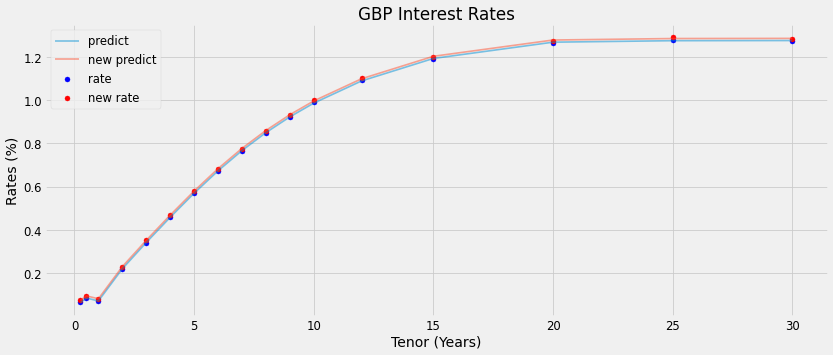

In [19]:
plot_scenario('scenario1')

### Scenario 2 - Short End Interest Rate Decreases

Model adjusted curvature accordingly

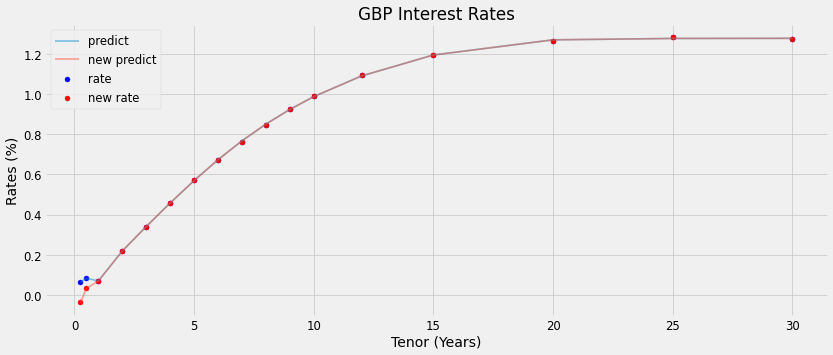

In [20]:
plot_scenario('scenario2')

### Scenario 3 - Possible Interest Rate Error

Model adjusted curvature slightly.  Not affected by one possible error on the 10-year interest rate.

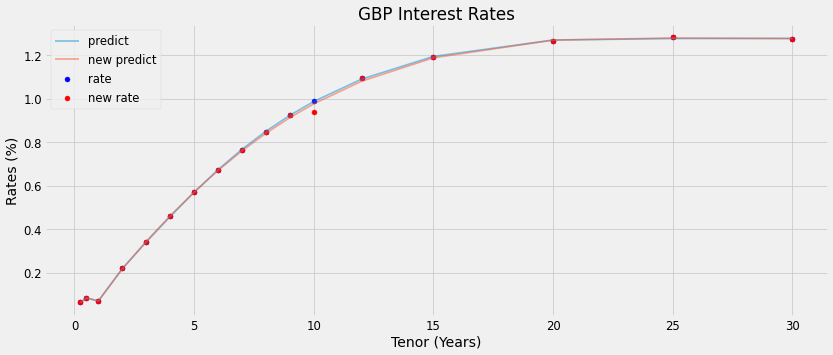

In [21]:
plot_scenario('scenario3')

### Scenario 4 - Long End Increase in Interest Rate

Model adjusted curvature accordingly

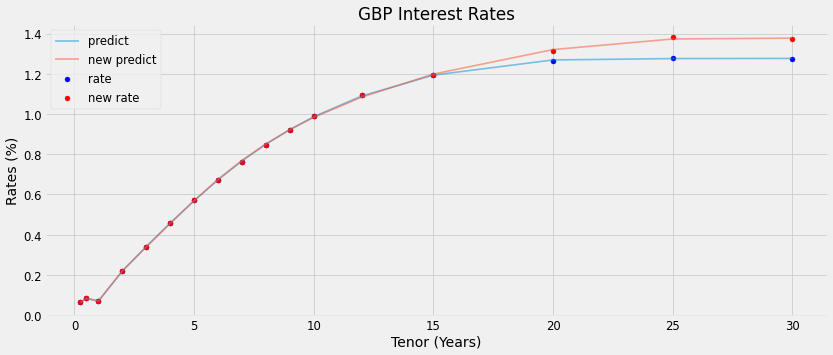

In [22]:
plot_scenario('scenario4')